# **Assignment MSc Data Science**: a VAE for binarised MNIST

In this assignment, you'll play a bit with a VAE on a binarised version of MNIST

# Loading useful stuff

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions

# Loading MNIST and binarising it

In [0]:
(train_images_nonbinary, y_train), (test_images_nonbinary,  y_test) = tf.keras.datasets.mnist.load_data()

train_images_nonbinary = train_images_nonbinary.reshape(train_images_nonbinary.shape[0], 28*28)
test_images_nonbinary = test_images_nonbinary.reshape(test_images_nonbinary.shape[0], 28*28)

y_train = tf.cast(y_train, tf.int64)
y_test =tf.cast(y_test, tf.int64)

11493376/11490434 [==============================] - 0s 0us/step


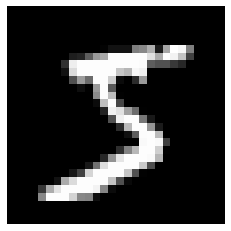

In [0]:
plt.imshow(train_images_nonbinary[0, :].reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

Then we binarise the data. There are many ways to do that. Here, we simply round the numbers, following the [TF tutorial on convolutional VAEs](https://www.tensorflow.org/tutorials/generative/cvae).

In [0]:
# Normalizing the images to the range of [0., 1.]
train_images = train_images_nonbinary/255.
test_images = test_images_nonbinary/255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

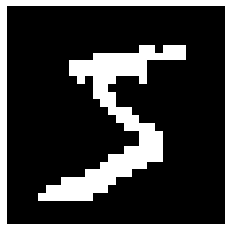

In [0]:
plt.imshow(train_images[0, :].reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

# Deep latent variable model

We will use a **deep latent variable model with a Gaussian prior and a Bernoulli observation model**. This can be written:

$$p_{\boldsymbol{\theta}}(\mathbf{x}_1,...,\mathbf{x}_n) = \prod_{i=1}^n p(\mathbf{x}_i|\mathbf{z}_i)p(\mathbf{z}_i),$$
$$p(\mathbf{z}_i) = \mathcal{N}(\mathbf{z}_i|\mathbf{0}_d,\mathbf{I}_d), $$
$$p_{\boldsymbol{\theta}}(\mathbf{x}_i|\mathbf{z}_i) = \mathcal{B} (\mathbf{x}_i|\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}_i)),$$

where $\boldsymbol{\pi}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{[0,1]}^p$ is a function (called the **decoder**) parametrised by a deep neural net.

In [0]:
d = 50 # dimension of the latent space

p_z = tfd.Independent(tfd.Normal(loc = tf.zeros(d, tf.float32), scale = tf.ones(d, tf.float32)),reinterpreted_batch_ndims=1)  # that's the prior

In [0]:
h = 200 # number of hidden units (same for all MLPs)

sigma = "relu"

decoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[d,]),
  tfkl.Dense(h, activation=sigma,kernel_initializer="orthogonal"),
  tfkl.Dense(h, activation=sigma,kernel_initializer="orthogonal"),
  tfkl.Dense(28*28) # the decoder will output both the mean, the scale, and the number of degrees of freedoms (hence the 3*p)
])

## Encoder

To be able to train our model, we will need an **encoder** (aka **inference network**), that will allow us to approximate the intractable posterior $p(\mathbf{z}|\mathbf{x})$.
The approximate posterior is defined as follows
$$ q(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mathbf{z} | \mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x} ), \text{Diag}(\mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x} )),
$$ 
where $\mathbf{x} \mapsto (\mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x} ), \mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x} ))$ is a function from the data space (i.e. $\{0,1\}^p$) to $\mathbb{R}^d \times [0, \infty[^d$ parametrised by a deep neural network. In other words, the encoder outputs the mean and the diagonal of the covariance matrix of the approximate posterior $q(\mathbf{z}|\mathbf{x})$.

In [0]:
encoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[28*28,]),
  tfkl.Dense(h, activation=sigma,kernel_initializer="orthogonal"),
  tfkl.Dense(h, activation=sigma,kernel_initializer="orthogonal"),
  tfkl.Dense(2*d) # 2*d because we need both the mean and the diagonal of the covariance
])

##The VAE objective

The **VAE objective** is defined as
$$
\mathcal{L}_1 (\boldsymbol{\theta,\gamma}) = \sum_{i=1}^n \mathbb{E}_{\mathbf{z} \sim q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}_i)} \left[ \log\frac{p_{\boldsymbol{\theta}}(\mathbf{x}_i|\mathbf{z})p(\mathbf{z})}{q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}_i)} \right].
$$

It is a lower bound of the likelihood of the deep latent variable model. Rather than the intractable likelihood, we'll **maximise this bound**.

To see more clearly the neural nets inside the objective, we may rewrite it as:
$$
\mathcal{L}_1 (\boldsymbol{\theta,\gamma}) = \sum_{i=1}^n \mathbb{E}_{\mathbf{z} \sim \mathcal{N}(\mathbf{z} | \mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x}_i ), \text{Diag}(\mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x}_i ))} \left[ \log\frac{\mathcal{B} (\mathbf{x}_i|\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}))\mathcal{N}(\mathbf{z}|\mathbf{0}_d,\mathbf{I}_d)}{\mathcal{N}(\mathbf{z} | \mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x}_i ), \text{Diag}(\mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x}_i ))} \right].
$$

**Create a TF function that computes an unbiased estimate of it!** (using a single sample from the approximate posterior)

A good way to go is to follow these steps, for all $\mathbf{x}_i$ in your batch:


*   Encode the batch fo data points, to get the $\mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x}_i ), \text{Diag}(\mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x}_i ))$ 
*   Use these encoder outputs to define $q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}_i)$ as a TF probability distribution
*   Take one sample $\mathbf{z}_i$ from $q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}_i)$, and use it to:
  *   Compute $\mathcal{B} (\mathbf{x}_i|\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}_i))$ by decoding $\mathbf{z}_i$
  *   Compute the rest of the log of $p(\mathbf{z}_i)$ and $q_{\boldsymbol{\gamma}}(\mathbf{z}_i|\mathbf{x}_i)$ using the $\texttt{.logprob}$ method from TF probability.






In [0]:
@tf.function
def vae_bound(data):

  # 
  
  return(bound)

Now optimise the objective!

In [0]:
params = list(encoder.trainable_variables) + list(decoder.trainable_variables)  

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [0]:
@tf.function
def train_step(data):
  with tf.GradientTape() as tape: # the gradient tape saves all the step that needs to be saved fopr automatic differentiation
    bound = vae_bound(data)
    loss = - bound
  gradients = tape.gradient(loss,params)  # here, the gradient is automatically computed
  optimizer.apply_gradients(zip(gradients, params))  # Adam iteration

In [0]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_images,y_train)).shuffle(60000).batch(batch_size) # TF creates the batches for us

Write a training loop to optimise the VAE bound. Print the values of the training/test bounds after each epoch to check that it's working.

In [0]:
EPOCHS = 20

for epoch in range(1,EPOCHS+1):
  for images, _ in train_dataset:
    ##

# Questions:

**1. Witnessing training**

Plot the evolution of training and test likelihood bounds during training.

Sample a bunch of digits (say, 20) from the model before, during, and after training.



**2. Playing with intialisation strategies**

What was the initialisation strategy used by default by Keras? Try different initialisation trategies that you learned in the course for the weights of the networks. Plot the training curves. Which ones do you think are better (in theory and in this particular example)?

**Hint** You may simply use the $\texttt{kernel_initialiser}$ argument:


```
  tfkl.Dense(h, activation=sigma, kernel_initializer='...'),
```





**3. Representation learning**

One of the applications of VAEs is to get a low-dimensional representation of the data. For example, one can replace the high-dimensional data points $\mathbf{x}_i$ by the mean of the corresponding approximate posteriors $\mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x}_i ) \in \mathbb{R}^d$.

Here, we trained a VAE with $d = 50$, which is not readily visualisable...

Study ways to visualise the encodings $\mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x}_i )$:

*   Use PCA on the $50$-dimensional embedding $\mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x}_i )$ to get a bidimensional embedding and visualise it!
*   Train another VAE with $d = 2$, this will be readily visualisable!

Which method do you think works best? Compare that to doing PCA with the original data.

**Bonus** Come up with a way to quantify which method is better.

**Bonus** Replace PCA by another dimension-reduction technique that you know.





**4. The reparametrisation trick**

Thanks to TF probability, we did not have to implement the reparametrisation trick (cf last slides of Lecture 4). It was implicitly (and automatically) used in the line of code:

```
zgivenx = q_zgivenx.sample(1)
```

Replace this line of code by your own implementation of the trick (see slides of Lecture 4). Check that it works. Of course, you're not allowed to use $\texttt{.sample}$

**5. The IWAE bound**

Implement the tighter IWAE bound, and see if it gives better results.

Whether or not you think that the IWAE is better or worse than the vanilla VAE, explain *why* you think so (faster/slower training? better/worse generative model? better/worse representation low-dimensional representation).

**Hint** The beginning of the function to compute the bound is exaclty the same, until the line 

```
zgivenx = q_zgivenx.sample(1)
```

that should be replaced by 

```
zgivenx = q_zgivenx.sample(K)
```
because you want to sample $K>1$ importance weights.

**Hint** The TF $\texttt{reduce_logsumexp}$ the computes the [logsumexp function](https://en.wikipedia.org/wiki/LogSumExp) might come in handy.

**Hint** For training, choose a small value of $K$ (say, between 5 and 50). It's much less computationnaly demanding.

**Hint** For testing, choosing a larger value of $K$ will give you a better estimate of the test log-likelihood, allowing you to evaluate the quality of *any DLVM* (at least any VAE or IWAE) more accurately.


**6. (Bonus) The KL trick**

Re-implement the VAE using the "KL trick" (cf Slide 14 of Lecture 4). If you already used the trick, implement a VAE *without* using it. Do you see a difference of convergence speed?

**Hint** You may use the TF Porbability function $\texttt{kl_divergence}$ or the exact formula for Gaussians (which will give the same results).

**7. (Bonus) Large scale IWAE bound**

Compute the test IWAE bound with $K = 5000$. This metric is a reasonably tigh bound of the true test log likelihood, and is actually the most commonly used to evaluate DLVMs. Use it to compare several VAEs or IWAEs where you change a few building blocks.

For example, you could compare several VAEs with different dimensions $d$, or compare an IWAE and a VAE, or try different activation functions, or network architectures...